In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

from cmdstanpy import CmdStanModel
import arviz as az

from glob import glob

import os

from scipy.ndimage import gaussian_filter

In [2]:
data = pd.read_csv('./dataStore/datas_2_larp.csv',index_col=0)
#data = pd.read_csv('./dataStore/microrheology.csv',index_col=0)

names = {'AlgVLVG0_0Ca_2mgmlcollagen':'Collagen',
        'AlgLVLG15_3Ca_2mgmlcollagen':'IPN soft',
        'AlgVLVG15_22Ca_2mgmlcollagen':'IPN medium',
        'AlgVLVG15_40Ca_2mgmlcollagen':'IPN stiff'}

data['type'] = data['type'].apply(lambda x: names[x])
data= data.reset_index(drop=True)

10.0


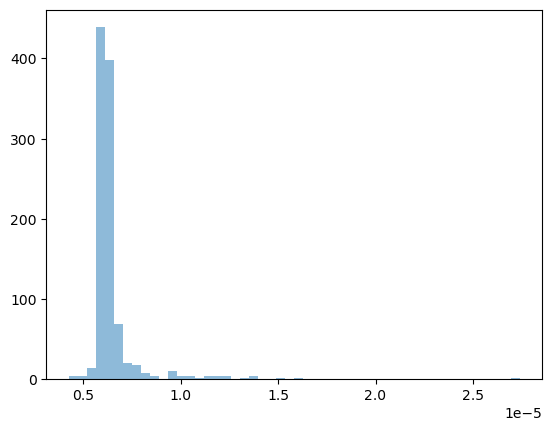

30.0


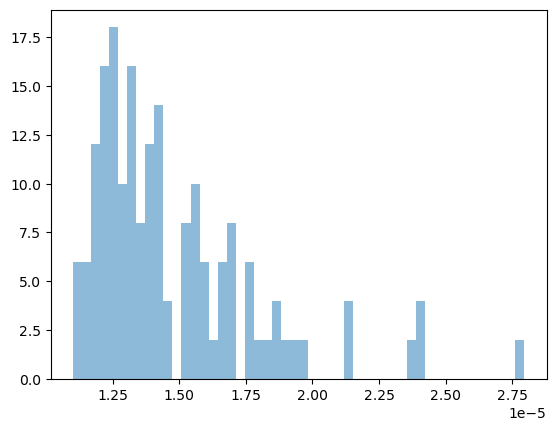

50.0


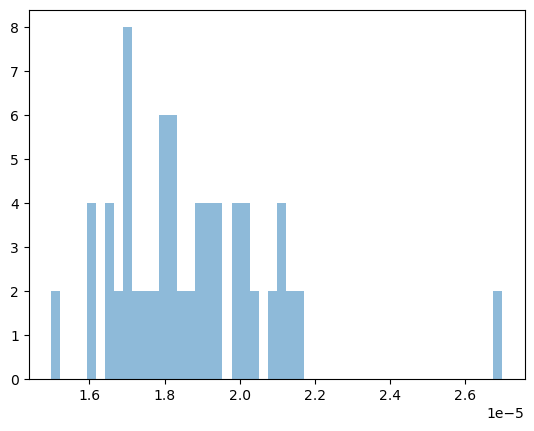

100.0


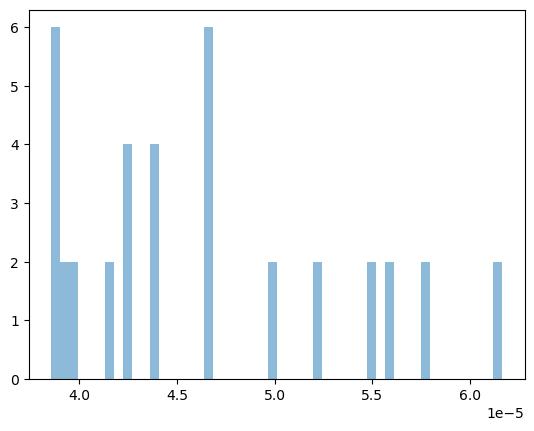

In [3]:
for k in data["size"].unique():

    sub_data = data[data["size"] == k]
    print(k)
    _ = plt.hist(sub_data["radius_(m)"], alpha = 0.5, bins = 50)
    plt.show()

In [4]:
for i in range(data.shape[0]):
    
    if data.loc[i,"size"] == 10.0:
        if (data.loc[i,"radius_(m)"] < 5e-6) | (data.loc[i,"radius_(m)"] > 7e-6):
            data.loc[i,"radius_(m)"] = 6e-6
            data.loc[i,"G_abs"] = np.abs(282743.3388230814*(4/3*np.pi*(5.5e-6)**3)/(3*np.pi*2*(5.5e-6)*(data.loc[i,"a_(um)"])*10**-6))
    elif data.loc[i,"size"] == 30.0:
        if (data.loc[i,"radius_(m)"] < 10e-6) | (data.loc[i,"radius_(m)"] > 20.5e-6):
            data.loc[i,"radius_(m)"] = 15e-6
            data.loc[i,"G_abs"] = np.abs(408407.04496667313*(4/3*np.pi*(15e-6)**3)/(3*np.pi*2*(15e-6)*(data.loc[i,"a_(um)"])*10**-6))

In [5]:
data_counts = data.groupby(['type','day', "sample",'holder','location','track_id']).size().reset_index(name="counts")

In [6]:
# create a Boolean mask for the rows to remove
mask = data['type'] == 'IPN stiff'

# select all rows except the ones that contain 'Coca Cola'
data = data[~mask].reset_index(drop=True)
data["size"] = data["size"].astype("int")

In [7]:
def _gen_indices(data,names,idx,indices,orig_indices):
    # generate running indices based on the hierarchy
    
    # break recursion if at the end of hierarchy
    if idx>=len(names):
        return indices,orig_indices
    for ii,i in data.groupby(names[idx]):
        counts = i.shape[0]
        latest = 1
        l = indices[names[idx]]
        if len(l) != 0:
            latest = l[-1]+1
        # add running indices to the current level hierarchy
        indices[names[idx]].extend([latest]*counts)
        orig_indices[names[idx]].extend([ii]*counts)
        indices,orig_indices = _gen_indices(i,names,idx+1,indices,orig_indices)
    return indices,orig_indices

def index(name):
    # index vector outside hierarchy
    indices = np.zeros(data.shape[0],dtype=int)
    orig = np.zeros(data.shape[0],dtype=object)
    for idx,i in enumerate(np.unique(data[name])):
        mask = data[name]==i
        indices[mask] = idx
        orig[mask] = i
    return indices,orig

In [8]:
# hierarcical indexing
gnames = ['type','day','sample','holder','location','track_id']
g_indices = {i:[] for i in gnames}
g_orig_indices = {i:[] for i in gnames}

indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)

# outside hierarchy
size_indices,size_orig = index('size')
coating_indices,coating_orig = index('coating')

In [9]:
# relative scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data.groupby('type')[x].transform('std'))

# global scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data[x].std())

# global scaling
#normalize = lambda x: data[x].sub(data[x].mean())\
#            .div(data[x].std())

normalize = lambda x: data[x].div(data[x].std())


data['G_abs_normed'] = normalize('G_abs')
data['phi_normed'] = normalize('phi_(rad)')
data['radius_(m)'] = normalize('radius_(m)')

In [10]:
data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}

#data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
#             **{f'{i}_ids':j for i,j in indices.items()},
#             'size_ids':(size_indices+1).tolist(),
#             'N_size':len(np.unique(size_indices)),
#             'y':data['G_abs_normed'].tolist(),
#             'N':data.shape[0]}


with open('./dataStore/data.json','w') as f:
    json.dump(data_json,f)

In [11]:
model = CmdStanModel(stan_file='./model/model_o.stan')
fit = model.sample(data='./dataStore/data.json', show_progress=True,adapt_delta=0.99,max_treedepth=15)
print(fit.diagnose())

10:40:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:45:04 - cmdstanpy - INFO - CmdStan done processing.
10:45:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to column 70)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'model_o.stan', line 54, column 2 to 


Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_on81zn8o9\model_o-20250103104013_1.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_on81zn8o9\model_o-20250103104013_2.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_on81zn8o9\model_o-20250103104013_3.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_on81zn8o9\model_o-20250103104013_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [12]:
def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

name_list = ['Collagen',"IPN-2.5", 'IPN-40' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

probabilities = comp_all(name_list, vals)

In [13]:
rheology_paths = glob("F:/instru_projects/rheology/rheology/*.csv")

listat = ["Collagen", "Collagen", "IPN-2.5", "IPN-2.5", "IPN-2.5", "IPN-40",  "IPN-40", "IPN-40"]

for i in range(len(rheology_paths)):
    current_path = rheology_paths[i]
    part = os.path.split(current_path)[1]
    parts = part.split("_")
    df_tmp = pd.read_csv(current_path, encoding='utf-16', delimiter="\t", decimal= ",")
    #
    del df_tmp[df_tmp.columns[0]]
    del df_tmp["Strain Hardening Index"]
    #df_tmp = df_tmp.replace(to_replace='None', value=np.nan).dropna()


    df_tmp["matrix"] = parts[0]
    df_tmp["day"] = parts[3]
    df_tmp["Ca"] = parts[5]
    df_tmp["run_num"] = int(parts[-1][:2])
    df_tmp["label"] = listat[i]

    if i == 0:
        df_macro = df_tmp
    else: 
        df_macro = pd.concat((df_macro, df_tmp))

df_macro.fillna(0)

df_osc = df_macro[df_macro["Time"] < 120]
df_freq = df_macro[(df_macro["Time"] < 180) & (df_macro["Time"] > 120)]
df_strain = df_macro[df_macro["Time"] > 180]




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\4038319177.py:36: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\4038319177.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\4038319177.py:41: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.

(0.0, 1.0, 0.0, 1.0)

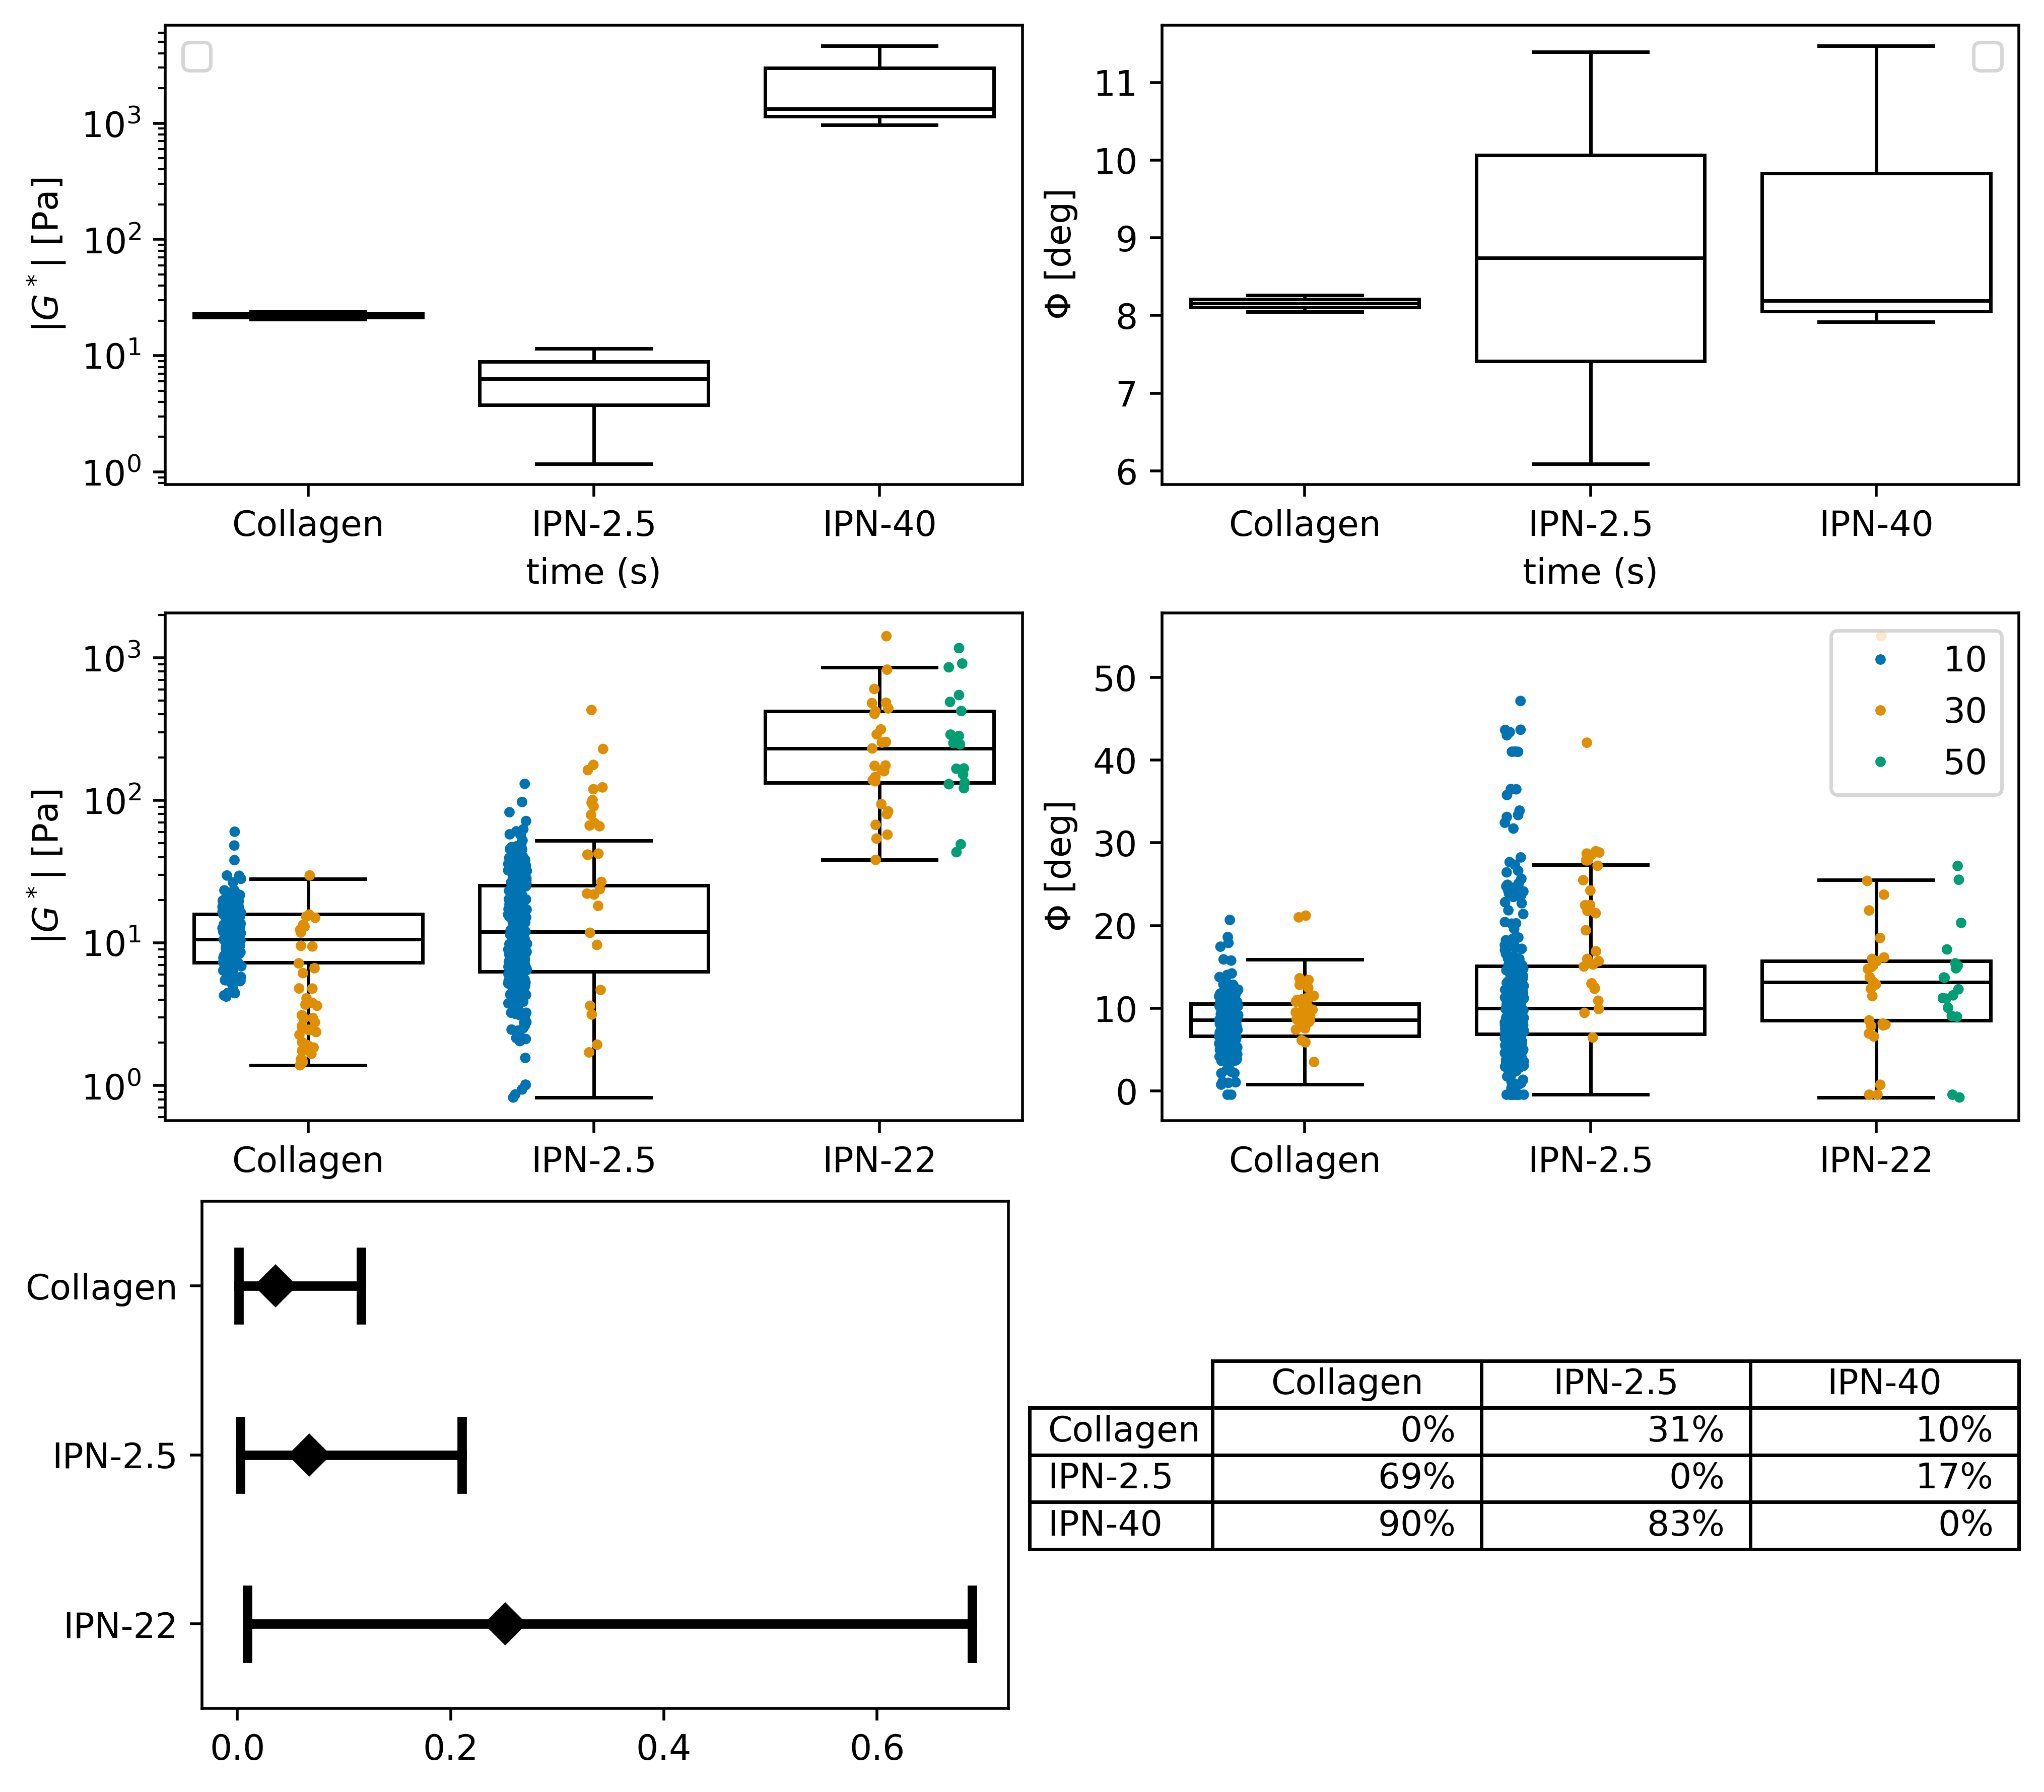

In [14]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(3, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1, 1])

ax0 = subfigs[0].subplots(1, 2)
ax1 = subfigs[1].subplots(1, 2)
ax2 = subfigs[2].subplots(1, 2)


df_osc_sub = df_osc[df_osc["Time"] == 100.0]

sns.boxplot(x="label", y = "Complex Shear Modulus", data = df_osc_sub, ax = ax0[0], showfliers= False, **PROPS)

ax0[0].set_yscale("log")
ax0[0].set_xlabel("time (s)")
ax0[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax0[0].legend("")
sns.boxplot(x="label", y = "Phase Shift Angle", data = df_osc_sub, ax = ax0[1], showfliers= False, **PROPS)
#ax[0].set_yscale("log")

ax0[1].set_xlabel("time (s)")
ax0[1].set_ylabel(r'${}$ [{}]'.format('\Phi','deg'))
ax0[1].legend(loc='upper right')



mm = data.groupby(['day', 'sample', 'holder', 'location','type','material', 'size', 'coating','track_id']).mean()

sns.boxplot(data=mm,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=mm,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','deg'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend(loc='upper right')
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )


In [15]:
azOut = az.from_cmdstanpy(posterior=fit,
                            posterior_predictive='y_hat',
                            log_likelihood='log_likelihood')

loo = az.loo(azOut,pointwise=True)
print(loo)

Computed from 4000 posterior samples and 1252 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1302.78    13.49
p_loo      460.52        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1249   99.8%
   (0.70, 1]   (bad)         3    0.2%
   (1, Inf)   (very bad)    0    0.0%



c:\Users\lehto\anaconda3\envs\stan_py\lib\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [29]:
# hierarcical indexing
#gnames = ['type','day','sample','holder','location','track_id']
#g_indices = {i:[] for i in gnames}
#g_orig_indices = {i:[] for i in gnames}
#indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)
## outside hierarchy
#size_indices,size_orig = index('size')
#coating_indices,coating_orig = index('coating')

# relative scaling
#normalize = lambda x: data[x].sub(data.groupby('type')[x].transform('mean'))\
#             .div(data.groupby('type')[x].transform('std'))

# global scaling
#normalize = lambda x: data[x].sub(data[x].mean())\
#            .div(data[x].std())

#global
#normalize = lambda x: data[x]\
#             .div(data[x].std())
#data['G_abs_normed'] = normalize('G_abs')
#data['phi_normed'] = normalize('phi_(rad)')
#data['radius_(m)'] = normalize('radius_(m)')

data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'x_size':data["radius_(m)"].tolist(),
             'bead_ids':(size_indices+1).tolist(), #
             'N_bead':len(np.unique(size_indices)), #
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}


with open('./dataStore/data_s.json','w') as f:
    json.dump(data_json,f)



In [30]:

model = CmdStanModel(stan_file='./model/model_o_linear_size.stan')
fit = model.sample(data='./dataStore/data_s.json', show_progress=True,adapt_delta=0.99,max_treedepth=15) #,adapt_delta=0.99,max_treedepth=15,adapt_delta=0.99,max_treedepth=15
print(fit.diagnose())

12:14:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:21:42 - cmdstanpy - INFO - CmdStan done processing.
12:21:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_linear_size.stan', line 74, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_linear_size.stan', line 74, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_linear_size.stan', line 74, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_linear_size.stan', line 74, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[375] is -inf, but must be finite! (in 'model_o_linear_size.stan', line 74, column 2 to column 90)
	Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_linear_size.stan', line 74, column 2 to column 90)
Exception: normal_lpdf: Location 


Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linear_size6u2prtov\model_o_linear_size-20250103121412_1.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linear_size6u2prtov\model_o_linear_size-20250103121412_2.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linear_size6u2prtov\model_o_linear_size-20250103121412_3.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linear_size6u2prtov\model_o_linear_size-20250103121412_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [34]:
def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

name_list = ['Collagen','IPN soft', 'IPN medium' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

probabilities = comp_all(name_list, vals)

C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\87338048.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\87338048.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\87338048.py:24: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\87338048.py:26: UserWarning: set_ticklabels() shoul

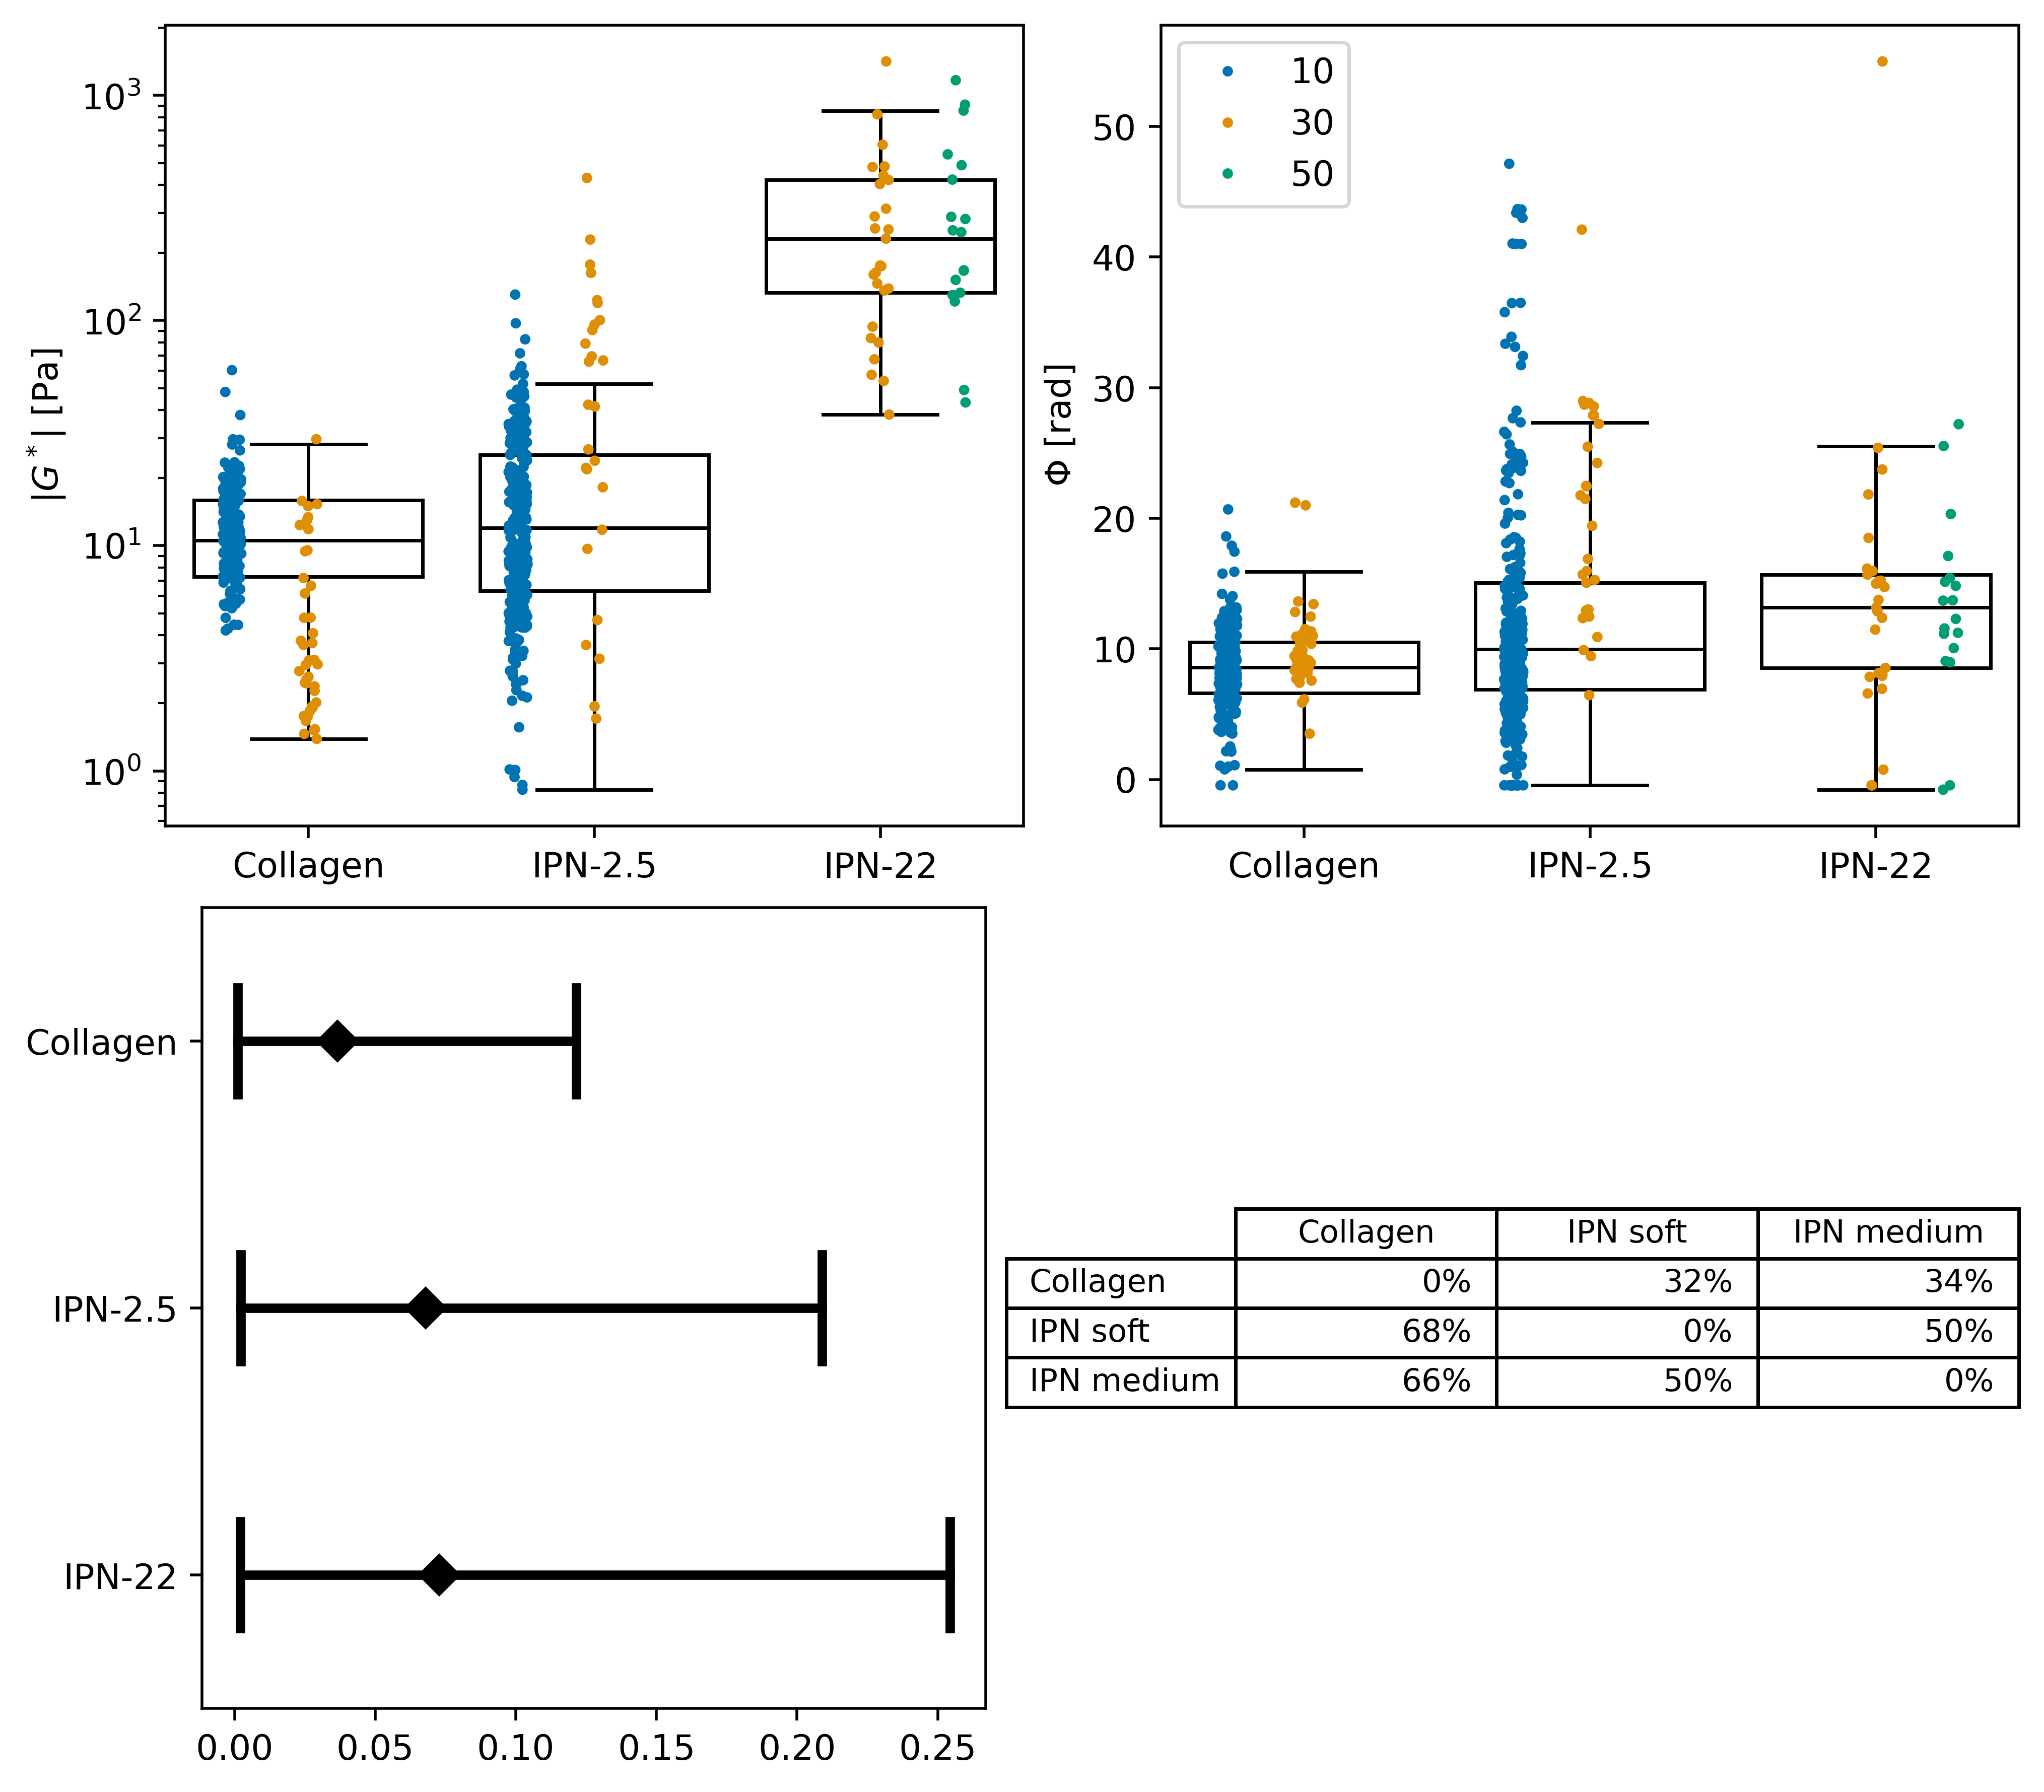

10um    0.016243
30um    0.062791
50um    0.892657
dtype: float64
collagen   -0.022554
IPN-2.5     0.034876
IPN-22mM    0.370390
dtype: float64


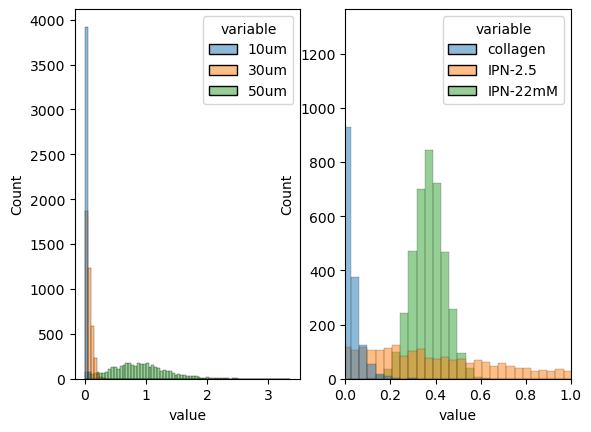

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(2, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 2)
ax2 = subfigs[1].subplots(1, 2)



PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

mm = data.groupby(['day', 'sample', 'holder', 'location','type','material', 'size', 'coating','track_id']).mean()

sns.boxplot(data=mm,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=mm,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend()
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )
plt.show()


fig,ax = plt.subplots(1,2)

vals = fit.draws_pd().filter(regex='^sigma_bead')
vals.columns = ['10um', "30um",'50um' ] #,'IPN stiff'
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[0])
print(vals.mean())
vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[1])
ax[1].set_xlim(0,1)
print(vals.mean())

In [36]:
azOut = az.from_cmdstanpy(posterior=fit,
                            posterior_predictive='y_hat',
                            log_likelihood='log_likelihood')

loo = az.loo(azOut,pointwise=True)
print(loo)

Computed from 4000 posterior samples and 1252 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1301.52    12.69
p_loo      464.46        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1250   99.8%
   (0.70, 1]   (bad)         2    0.2%
   (1, Inf)   (very bad)    0    0.0%



c:\Users\lehto\anaconda3\envs\stan_py\lib\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [21]:
# hierarcical indexing
#gnames = ['type','day','sample','holder','location','track_id']
#g_indices = {i:[] for i in gnames}
#g_orig_indices = {i:[] for i in gnames}
#indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)
## outside hierarchy
#size_indices,size_orig = index('size')
#coating_indices,coating_orig = index('coating')
#normalize = lambda x: data[x]\
#             .div(data[x].std())
#data['G_abs_normed'] = normalize('G_abs')
#data['phi_normed'] = normalize('phi_(rad)')
#data['radius_(m)'] = normalize('radius_(m)')

data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'bead_ids':(size_indices+1).tolist(), #
             'N_bead':len(np.unique(size_indices)), #
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}


with open('./dataStore/data_s.json','w') as f:
    json.dump(data_json,f)



model = CmdStanModel(stan_file='./model/model_o_size.stan')
fit = model.sample(data='./dataStore/data_s.json', show_progress=True,adapt_delta=0.99,max_treedepth=15) #,adapt_delta=0.99,max_treedepth=15
print(fit.diagnose())

10:52:51 - cmdstanpy - INFO - compiling stan file C:\Users\lehto\git\InstruProject\microrheology\model\model_o_size.stan to exe file C:\Users\lehto\git\InstruProject\microrheology\model\model_o_size.exe
10:53:12 - cmdstanpy - INFO - compiled model executable: C:\Users\lehto\git\InstruProject\microrheology\model\model_o_size.exe
10:53:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:00:58 - cmdstanpy - INFO - CmdStan done processing.
11:00:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_size.stan', line 62, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_size.stan', line 62, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[459] is -inf, but must be finite! (in 'model_o_size.stan', line 62, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[549] is inf, but must be finite! (in 'model_o_size.stan', line 62, column 2 to column 80)
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'model_o_size.stan', line 62, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'model_o_size.stan', line 62, column 2 to column 80)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'm


Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_size1xlcvqv3\model_o_size-20250103105312_1.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_size1xlcvqv3\model_o_size-20250103105312_2.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_size1xlcvqv3\model_o_size-20250103105312_3.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_size1xlcvqv3\model_o_size-20250103105312_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\1095849862.py:46: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\1095849862.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\1095849862.py:51: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\1095849862.py:53: UserWarning: set_ticklabels

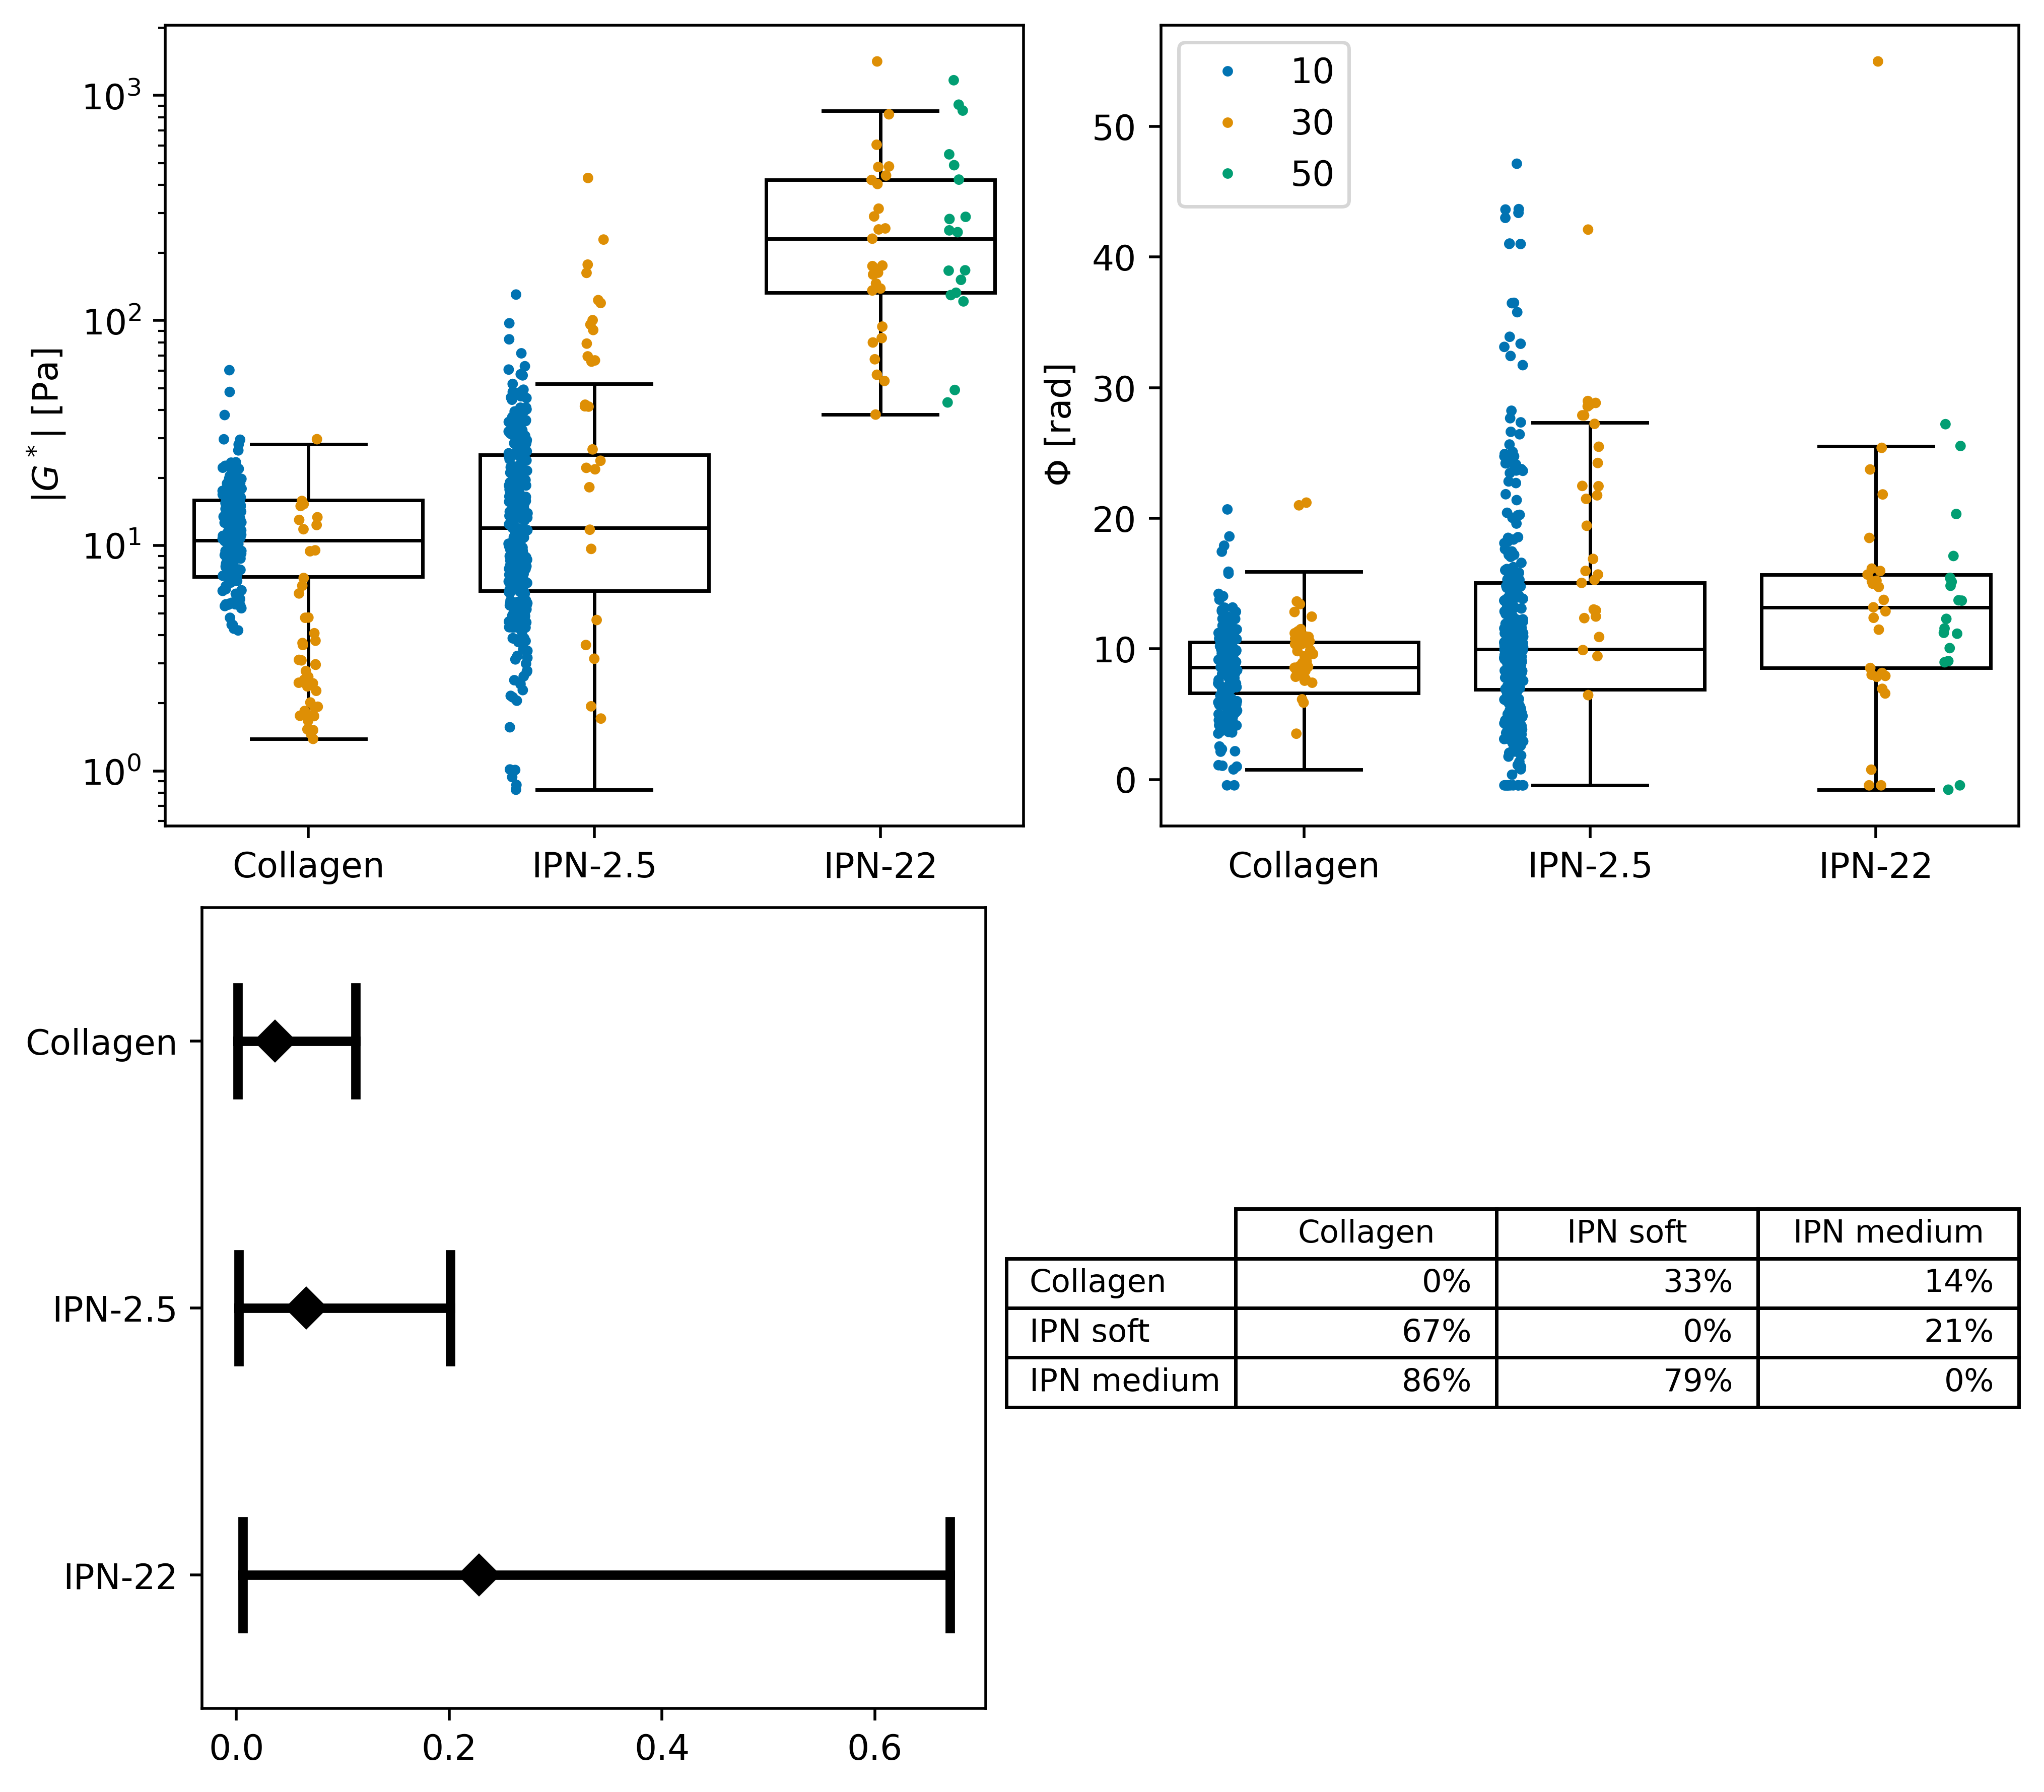

10um    0.016128
30um    0.056600
50um    0.886768
dtype: float64


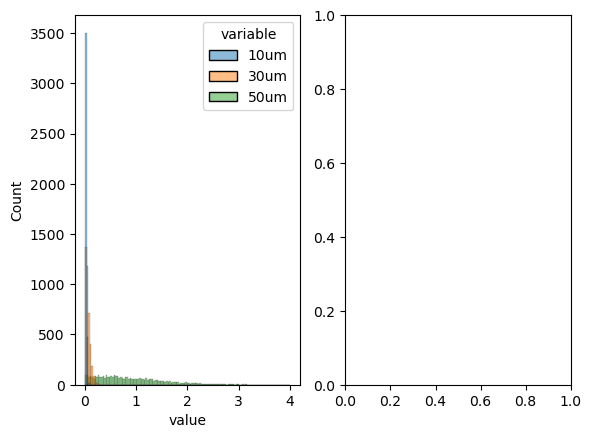

In [23]:
def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

name_list = ['Collagen','IPN soft', 'IPN medium' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

probabilities = comp_all(name_list, vals)

fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(2, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 2)
ax2 = subfigs[1].subplots(1, 2)



PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

mm = data.groupby(['day', 'sample', 'holder', 'location','type','material', 'size', 'coating','track_id']).mean()

sns.boxplot(data=mm,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=mm,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend()
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )
plt.show()


fig,ax = plt.subplots(1,2)

vals = fit.draws_pd().filter(regex='^sigma_bead')
vals.columns = ['10um', "30um",'50um' ] #,'IPN stiff'
sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[0])
print(vals.mean())

#vals = fit.draws_pd().filter(regex='^alpha')
#vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'
#sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[1])
#ax[1].set_xlim(0,1)
#print(vals.mean())

In [24]:
azOut = az.from_cmdstanpy(posterior=fit,
                            posterior_predictive='y_hat',
                            log_likelihood='log_likelihood')

loo = az.loo(azOut,pointwise=True)
print(loo)

Computed from 4000 posterior samples and 1252 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1304.95    13.03
p_loo      469.47        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1251   99.9%
   (0.70, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    0    0.0%



c:\Users\lehto\anaconda3\envs\stan_py\lib\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [25]:
# hierarcical indexing
#gnames = ['type','day','sample','holder','location','track_id']
#g_indices = {i:[] for i in gnames}
#g_orig_indices = {i:[] for i in gnames}
#indices,orig_indices = _gen_indices(data,gnames,0,g_indices,g_orig_indices)
## outside hierarchy
#size_indices,size_orig = index('size')
#coating_indices,coating_orig = index('coating')
#normalize = lambda x: data[x]\
#             .div(data[x].std())
#data['G_abs_normed'] = normalize('G_abs')
#data['phi_normed'] = normalize('phi_(rad)')
#data['radius_(m)'] = normalize('radius_(m)')

data_json = {**{f'N_{i}':len(np.unique(j)) for i,j in indices.items()},
             **{f'{i}_ids':j for i,j in indices.items()},
             'x_size':data["radius_(m)"].tolist(),
             'y':data['G_abs_normed'].tolist(),
             'N':data.shape[0]}


with open('./dataStore/data_s.json','w') as f:
    json.dump(data_json,f)



model = CmdStanModel(stan_file='./model/model_o_linear.stan')
fit = model.sample(data='./dataStore/data_s.json', show_progress=True,adapt_delta=0.99,max_treedepth=15) #,adapt_delta=0.99,max_treedepth=15
print(fit.diagnose())

12:06:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:11:45 - cmdstanpy - INFO - CmdStan done processing.
12:11:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'model_o_linear.stan', line 66, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in 'model_o_linear.stan', line 66, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[549] is -inf, but must be finite! (in 'model_o_linear.stan', line 66, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'model_o_linear.stan', line 66, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[549] is -inf, but must be finite! (in 'model_o_linear.stan', line 66, column 2 to column 80)
Exception: normal_lpdf: Location parameter[549] is -inf, but must be finite! (in 'model_o_linear.stan', line 66, column 2 to column 80)
	Exception: normal_lpdf: Location parameter[549] is -inf, but must


Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linearqdwg86zz\model_o_linear-20250103120650_1.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linearqdwg86zz\model_o_linear-20250103120650_2.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linearqdwg86zz\model_o_linear-20250103120650_3.csv, C:\Users\lehto\AppData\Local\Temp\tmp5yu0updz\model_o_linearqdwg86zz\model_o_linear-20250103120650_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\758067011.py:46: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\758067011.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\758067011.py:51: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')
C:\Users\lehto\AppData\Local\Temp\ipykernel_20088\758067011.py:53: UserWarning: set_ticklabels() s

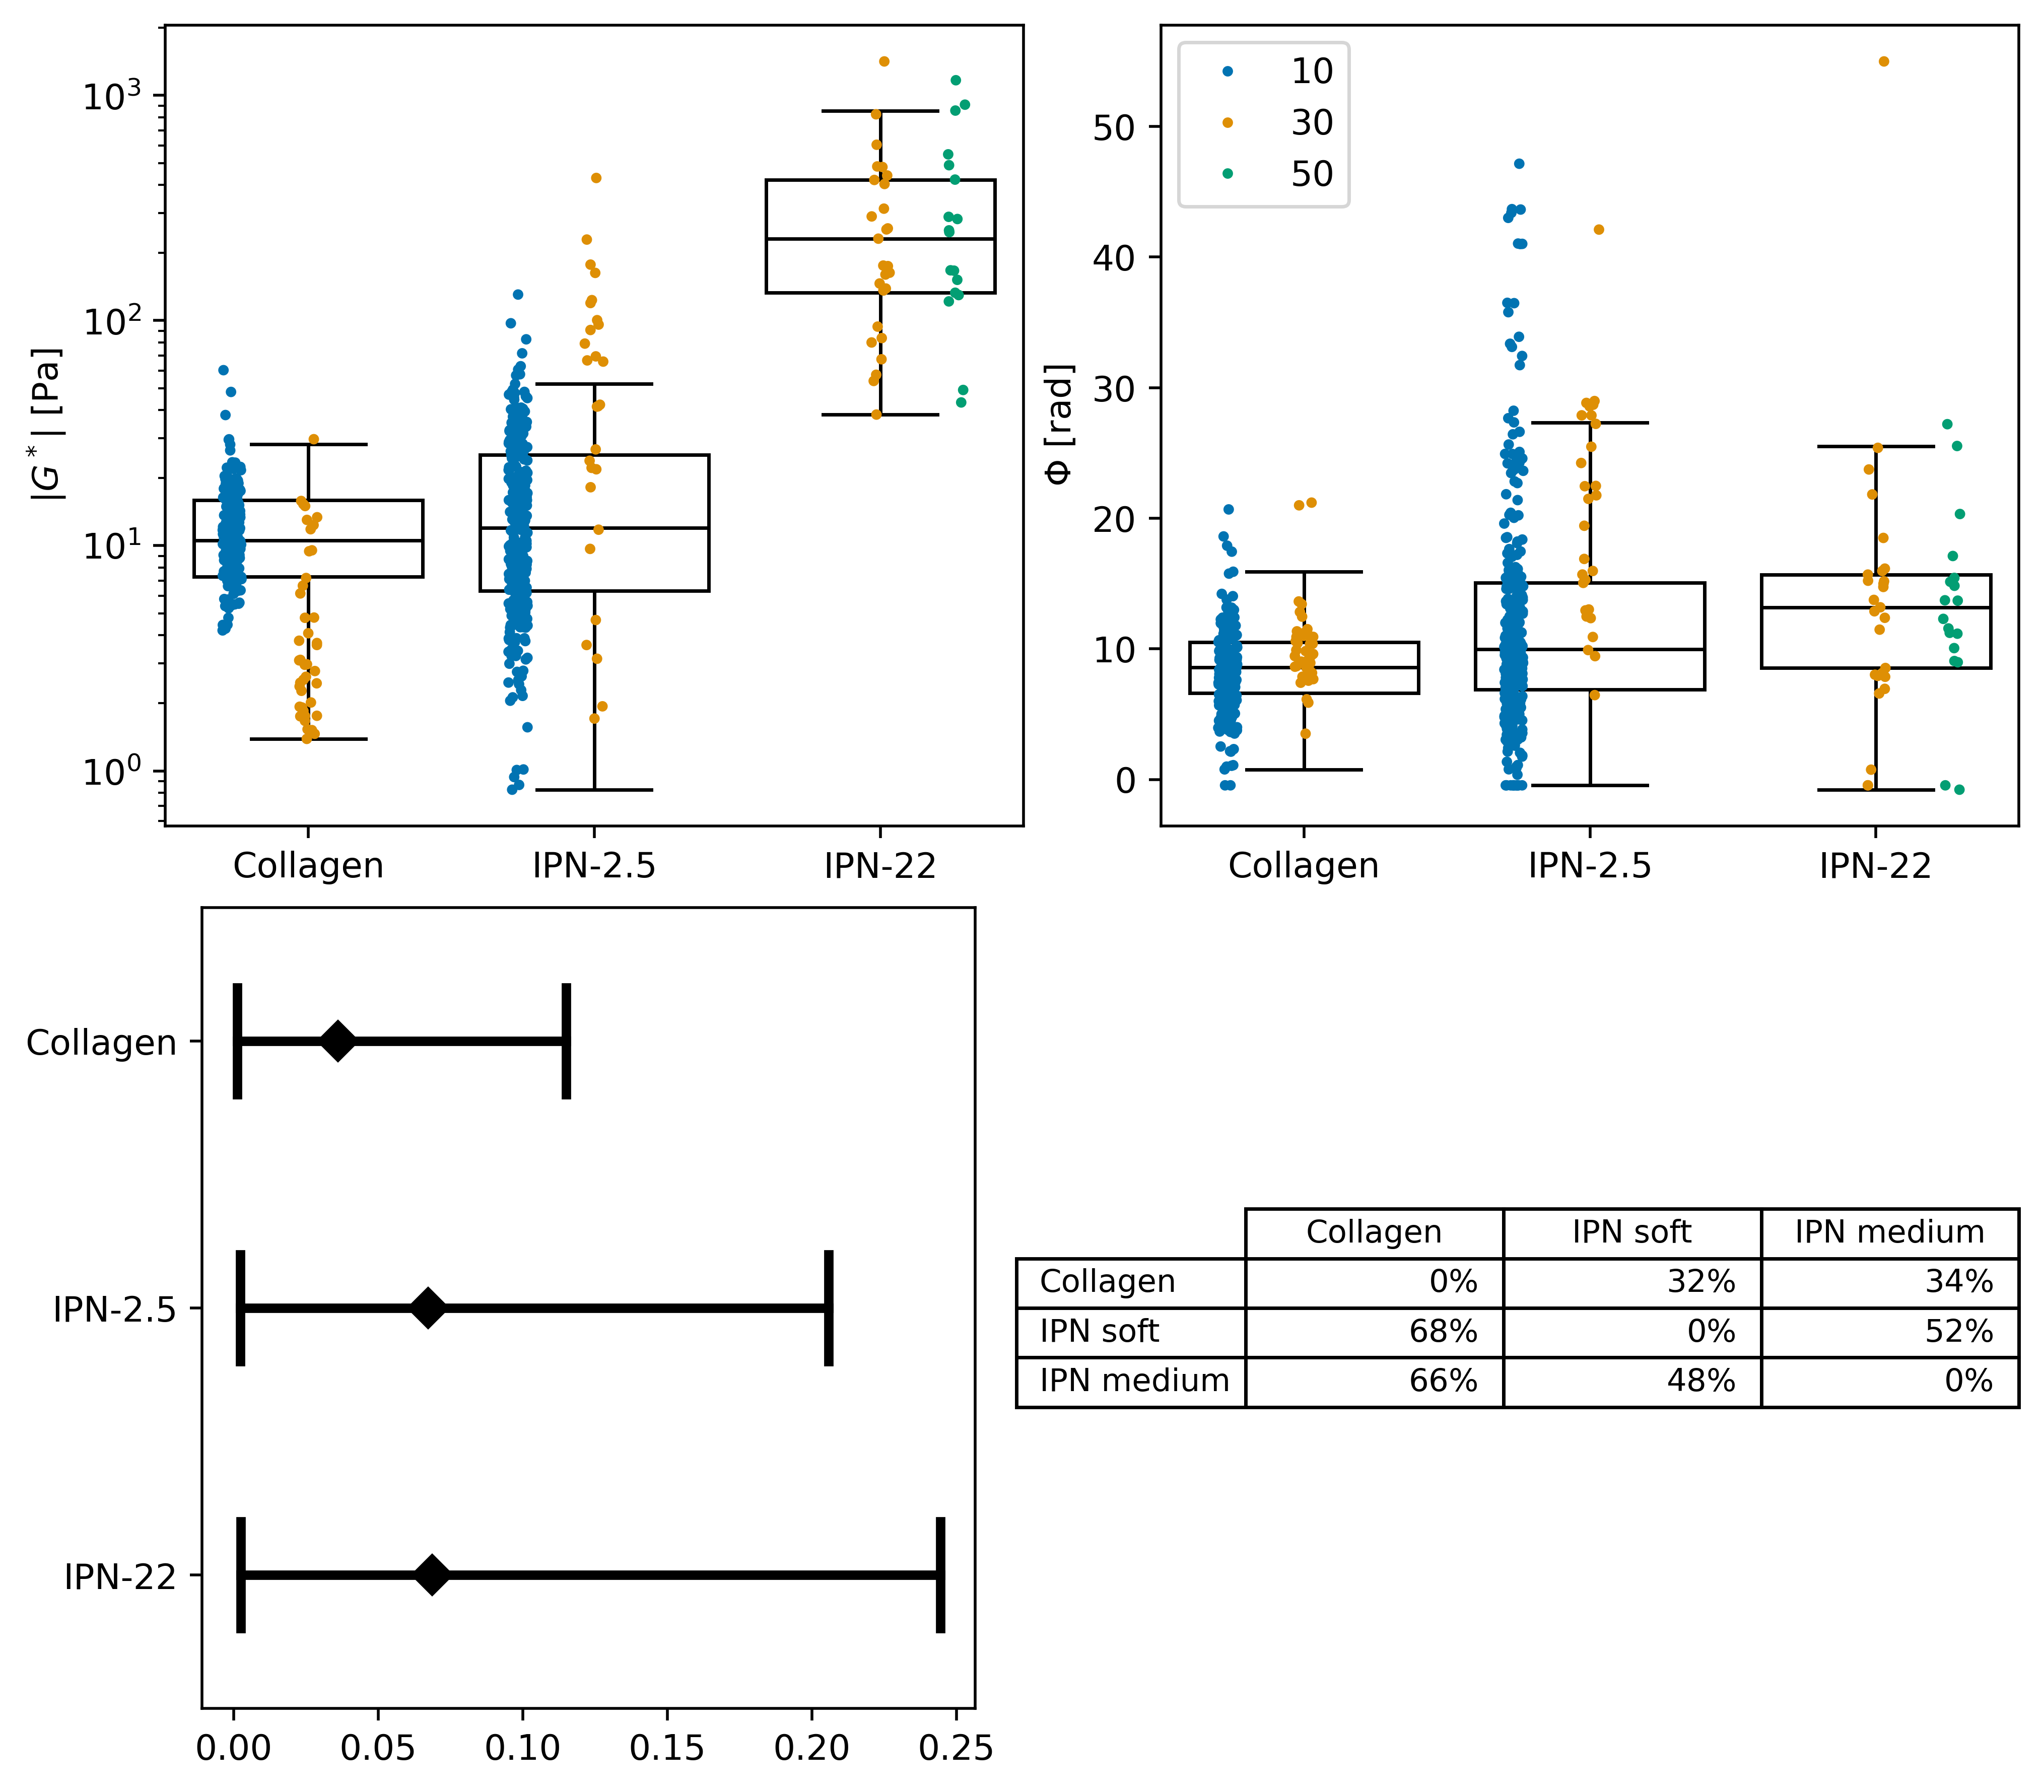

collagen   -0.023204
IPN-2.5     0.018726
IPN-22mM    0.331162
dtype: float64


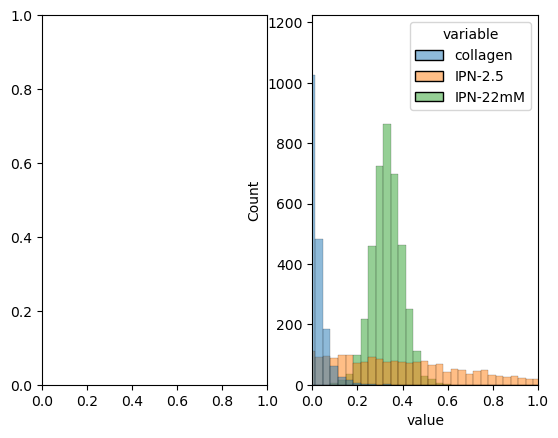

In [26]:
def comp(name1,name2,df):
    a = df[name1].values
    b = df[name2].values
    r = np.sum((a-b)>0)/a.shape[0]
    label = 'P( {} > {} ) = {:.4f}'.format(name1,name2,r)
    return r

def comp_all(names,df):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            #if i != j:
            probs[i][j] = comp(i,j,df)
    return probs

az_sample = az.from_cmdstanpy(fit,posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':data_json['y']})

name_list = ['Collagen','IPN soft', 'IPN medium' ]

vals = fit.draws_pd().filter(regex='^sigma_holder')
vals.columns =  name_list #,'IPN stiff'

probabilities = comp_all(name_list, vals)

fig = plt.figure(constrained_layout=True, figsize=(8,7),dpi = 500)
subfigs = fig.subfigures(2, 1, wspace=0.0025, hspace=0.0025, height_ratios=[1, 1])

ax1 = subfigs[0].subplots(1, 2)
ax2 = subfigs[1].subplots(1, 2)



PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

mm = data.groupby(['day', 'sample', 'holder', 'location','type','material', 'size', 'coating','track_id']).mean()

sns.boxplot(data=mm,x='type', y='G_abs',ax=ax1[0], showfliers= False, **PROPS)
sns.stripplot(data= mm, x='type',y='G_abs',ax=ax1[0], hue = "size", palette=sns.color_palette('colorblind'), legend=False, dodge = True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "Soft IPN", "Mid IPN", "Stiff IPN"])

sns.boxplot(data=mm,x='type', y='phi_(deg)',ax=ax1[1], showfliers = False, **PROPS)
sns.stripplot(data= mm, x='type',y='phi_(deg)',ax=ax1[1], hue = "size", palette=sns.color_palette('colorblind'), dodge=True, size =3, marker='o')

ax1[0].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[1].set_xticklabels(["Collagen", "IPN-2.5", "IPN-22", "IPN-40"])
ax1[0].set_title('')
ax1[1].set_title('')
ax1[0].set_ylabel(r'${}$ [{}]'.format('|G^*|','Pa'))
ax1[1].set_ylabel(r'${}$ [{}]'.format('\Phi','rad'))
ax1[0].set_xlabel("")
ax1[1].set_xlabel("")
ax1[1].legend()
ax1[0].set_yscale("log")

df = vals.melt()
sns.pointplot(
    data=df, x="value", y="variable",
    errorbar=("pi", 95), capsize=.4,
    color="black", linestyle="none", marker="D", ax=ax2[0]
)
ax2[0].set_ylabel("")
ax2[0].set_xlabel("")
ax2[0].set_yticklabels(["Collagen", "IPN-2.5", "IPN-22"])


columns = name_list
rows = name_list

# Plot bars and create text labels for the table
cell_text = []
for col_ in columns:
    row_text = []
    for row_ in rows:
        row_text.append(r"{}$\%$".format(int(np.round(probabilities[col_][row_]*100,0))))
    cell_text.append(row_text)

# Reverse colors and text labels to display the last value at the top.
#cell_text.reverse()

# Add a table at the bottom of the Axes
the_table = ax2[1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='center')

ax2[1].axis("off")
#fig.tight_layout()

#fig.savefig("./NikonPipes/dataStore/microrheology.png",transparent=False,facecolor='white' )
plt.show()


fig,ax = plt.subplots(1,2)

#vals = fit.draws_pd().filter(regex='^sigma_bead')
#vals.columns = ['10um', "30um",'50um' ] #,'IPN stiff'
#sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[0])
#
#print(vals.mean())

vals = fit.draws_pd().filter(regex='^alpha')
vals.columns = ['collagen', "IPN-2.5",'IPN-22mM' ] #,'IPN stiff'

sns.histplot(data=vals.melt(),x='value',hue='variable',ax=ax[1])
ax[1].set_xlim(0,1)
print(vals.mean())

In [27]:
azOut = az.from_cmdstanpy(posterior=fit,
                            posterior_predictive='y_hat',
                            log_likelihood='log_likelihood')

loo = az.loo(azOut,pointwise=True)
print(loo)

Computed from 4000 posterior samples and 1252 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1302.62    13.24
p_loo      457.44        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1250   99.8%
   (0.70, 1]   (bad)         1    0.1%
   (1, Inf)   (very bad)    1    0.1%



c:\Users\lehto\anaconda3\envs\stan_py\lib\site-packages\arviz\stats\stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
